In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from keras_preprocessing.sequence import pad_sequences

df = pd.read_pickle('final_df.pkl')
X= df['tokenized']
y= df['sentiment']

##0.2 so that training data is 80% and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69, stratify = y)

## Changing it to a list of lists as input to Word2Vec
corpus = list(X_train)

##Defining the size and running w2v
##size was 512
size = 300
w2v_model = Word2Vec(sentences=corpus, vector_size = size, sg=1)
word_vectors = w2v_model.wv

##Tokenizing
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(corpus)
dic_vocabulary = tokenizer.word_index

##Padding the sequences
maxlen = 100
train_token_seq = tokenizer.texts_to_sequences(corpus)
X_train_pad = pad_sequences(train_token_seq, maxlen=maxlen, padding="post", truncating="post")

##Preprocessin the test set
corpus2 = list(X_test)
tokenizer.fit_on_texts(corpus)
X_test_seq = tokenizer.texts_to_sequences(corpus2)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding="post", truncating="post")

## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, size))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  word_vectors[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

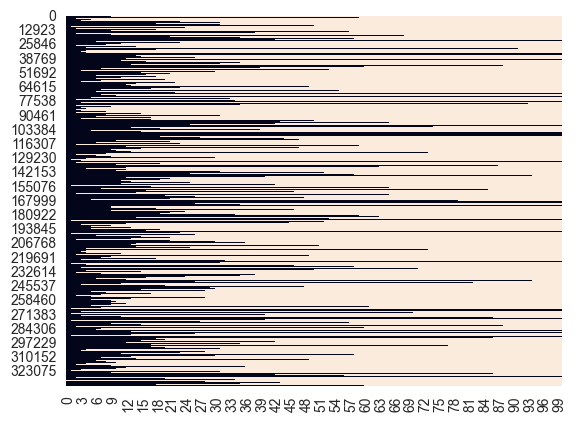

In [2]:
##Visuzaling the padding on the train set
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(X_train_pad==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [3]:
"""""
https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
"""""

import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [4]:
import keras
from keras import Sequential
from keras.layers import Embedding, SimpleRNN, Dropout, Dense
model = Sequential()
model.add(Embedding(input_dim=embeddings.shape[0], output_dim=embeddings.shape[1],
                    weights=[embeddings], input_length=X_train_pad.shape[1], trainable=False, input_shape=(maxlen,), mask_zero=True))
model.add(SimpleRNN(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[get_f1])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          53060100  
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                23360     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 53,083,525
Trainable params: 23,425
Non-trainable params: 53,060,100
_________________________________________________________________


In [5]:
##Defining class weight, since positive class is twice as big as the negative class
rnn_model = model.fit(X_train_pad, y_train, batch_size=64, epochs=5)

Epoch 1/5
5250/5250 [==============================] - 128s 24ms/step - loss: 0.2860 - get_f1: 0.9135
Epoch 2/5
5250/5250 [==============================] - 130s 25ms/step - loss: 0.2436 - get_f1: 0.9281
Epoch 3/5
5250/5250 [==============================] - 130s 25ms/step - loss: 0.2324 - get_f1: 0.9313
Epoch 4/5
5250/5250 [==============================] - 130s 25ms/step - loss: 0.2260 - get_f1: 0.9337
Epoch 5/5
5250/5250 [==============================] - 130s 25ms/step - loss: 0.2207 - get_f1: 0.9353


import matplotlib.pyplot as plt

plt.plot(rnn_model.history['get_f1'])
plt.plot(rnn_model.history['val_get_f1'])
plt.title('model F1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(rnn_model.history['loss'])
plt.plot(rnn_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [6]:
predictions = model.predict(X_test_pad)
rnn_predictions = list(map(lambda x: 0 if x<0.5 else 1, predictions))

2625/2625 [==============================] - 23s 9ms/step


In [7]:
from sklearn.metrics import f1_score
f1_score(y_test, rnn_predictions)

0.9262128079702014

In [8]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_test, rnn_predictions), recall_score(y_test, rnn_predictions)

(0.9516756736816866, 0.9020769956991503)

In [9]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, rnn_predictions)

array([[24178,  2620],
       [ 5601, 51597]], dtype=int64)